<a href="https://colab.research.google.com/github/Aakaey181/RA_Porject_ML1/blob/main/Module2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction** <br>
In this module, we will walk through an end-to-end project to build a binary classifier that detects the presence of zebra crossings in road images as an example of our customize courseware model training. Inspired by the Analytics Vidhya tutorial, our workflow covers the following steps: <br>

*   Model building and transfer learning (using MobileNetV2 pre-trained on ImageNet)
*   Cross-validation using StratifiedShuffleSplit
*   Model evaluation, including F1 Score calculation

Vidhya tutorial link: https://medium.com/analytics-vidhya/how-to-train-a-neural-network-classifier-on-imagenet-using-tensorflow-2-ede0ea3a35ff


---
<br>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install numpy pandas matplotlib
!pip install scikit-learn
!pip install tensorflow
!pip install tensorflow-addons
!pip install duckduckgo-search

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 33.3 MB/s eta 0:00:00


In [ ]:
import os
import shutil
import random
import numpy as np
import tensorflow as tf
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
import tensorflow.keras.applications.mobilenet_v2 as mobilenet_v2
from google.colab import drive

In [ ]:
import os
import sys

file_path = '/content/drive/MyDrive/ra/ml_utils.py'
file_dir = os.path.dirname(file_path)  # Get the directory containing ml_utils.py

if os.path.exists(file_path):
    print(f"The file '{file_path}' exists.")
    # Add the directory to Python's search path
    sys.path.append(file_dir)
    import ml_utils as mu
else:
    print(f"The file '{file_path}' does not exist. Please check the path and file name.")

The file '/content/drive/MyDrive/ra/ml_utils.py' exists.


# 2. Model Building with Transfer Learning

## 2.1

Code Operations:

- Compiling the Model:<br>
We build a model using MobileNetV2 as the base (frozen weights), add a global average pooling layer, a dense layer with ReLU, Dropout, and a final Dense layer with sigmoid activation for binary classification.

<br>
referrence

In [ ]:

# Define a Function to Build the Model
def build_model():
    """
    Builds and compiles a binary classification model using MobileNetV2 as the base.
    """
    base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

    base_model.trainable = False  # Freeze the pre-trained layers

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(1, activation="sigmoid")  # Output probability for binary classification
    ])
    model.compile(optimizer="adam",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

In [ ]:
# TODO:

BASE_DATA_DIR = "drive/MyDrive/ra/data"
RAW_IMAGE_DIR = os.path.join(BASE_DATA_DIR, "raw_images")

TARGET = "crater"  # could be "zebra_crossing", "traffic_light", ...

pos_pattern = f"road_{TARGET}"
neg_pattern = f"road_without_{TARGET}"

all_folders = os.listdir(RAW_IMAGE_DIR)
pos_folders = [f for f in all_folders if pos_pattern in f]
neg_folders = [f for f in all_folders if neg_pattern in f]

if len(pos_folders) != 1 or len(neg_folders) != 1:
    raise ValueError(
        f"Expect one pos folder matching '{pos_pattern}' and one neg matching '{neg_pattern}'.\n"
        f"Found pos: {pos_folders}, neg: {neg_folders}"
    )

class_names = pos_folders + neg_folders
print("Classes found:", class_names)

file_paths, labels = [], []
for cls_name in class_names:
    cls_folder = os.path.join(RAW_IMAGE_DIR, cls_name)
    label = 1 if cls_name in pos_folders else 0
    for fname in os.listdir(cls_folder):
        file_paths.append(os.path.join(cls_folder, fname))
        labels.append(label)

file_paths = np.array(file_paths)
labels     = np.array(labels)

print(f"Total images:", len(file_paths),
      "| positives:", int(labels.sum()), "negatives:", int(len(labels)-labels.sum()))

Classes found: ['road_crater', 'road_without_crater']
Total images: 860 | positives: 359 negatives: 501


## 2.2  Cross-Validation with StratifiedShuffleSplit

Code Operations:

- Using StratifiedShuffleSplit: <br>
Instead of pre-splitting data into train/val folders, we collect all file paths and labels from our raw images and use StratifiedShuffleSplit to generate train/val splits. This ensures each split preserves class proportions.

<br>
explain how the cross-validation work

In [ ]:
# Set Up StratifiedShuffleSplit for Cross Validation

# Splits the data into several k=5 folds (5 splits)

n_splits = 5
test_size = 0.2  # 80% training, 20% cross validation for each split
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=42)

print("Total images for cross validation:", len(file_paths))

# Cross Validation Loop - Train and Evaluate the Model for Each Fold
fold = 1
fold_accs = []
fold_losses = []

for train_idx, val_idx in sss.split(file_paths, labels):
    print(f"\n===== Fold {fold} =====")
    # Split file paths and labels into training and validation sets for this fold
    train_paths, val_paths = file_paths[train_idx], file_paths[val_idx]
    train_labels, val_labels = labels[train_idx], labels[val_idx]

    # Create tf.data.Datasets using your pre-defined create_dataset function
    train_ds = mu.create_dataset(train_paths, train_labels)
    val_ds = mu.create_dataset(val_paths, val_labels)

    # Build a fresh model for this fold
    model = build_model()
    model.summary()

    # Train the model
    history = model.fit(train_ds, validation_data=val_ds, epochs=10) #defaut epochs = 10

    # Evaluate on the validation set
    loss, acc = model.evaluate(val_ds)
    print(f"Fold {fold} - Validation Accuracy: {acc:.2f}, Loss: {loss:.4f}")
    fold_accs.append(acc)
    fold_losses.append(loss)

    fold += 1

# Calculate and print average performance metrics across all folds
avg_acc = np.mean(fold_accs)
avg_loss = np.mean(fold_losses)
print(f"\nAverage Validation Accuracy over {n_splits} folds: {avg_acc:.2f}")
print(f"Average Validation Loss over {n_splits} folds: {avg_loss:.4f}")

Total images for cross validation: 860

===== Fold 1 =====
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 124s 5s/step - accuracy: 0.6636 - loss: 0.6687 - val_accuracy: 0.8837 - val_loss: 0.3371
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - accuracy: 0.8946 - loss: 0.2921 - val_accuracy: 0.8953 - val_loss: 0.3032
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.9231 - loss: 0.2270 - val_accuracy: 0.8895 - val_loss: 0.2873
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.9378 - loss: 0.1972 - val_accuracy: 0.8895 - val_loss: 0.2952
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.9390 - loss: 0.1674 - val_accuracy: 0.8663 - val_loss: 0.3316
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.9540 - loss: 0.1419 - val_accuracy: 0.8430 - val_loss: 0.3539
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.9480 - loss: 0.1582 - val_accuracy: 0.8372 - val_loss: 0.4041
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - accuracy: 0.9543 - loss: 0.1395 - val_accuracy: 0.8372 - val_loss

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.6968 - loss: 0.6341 - val_accuracy: 0.8314 - val_loss: 0.3585
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - accuracy: 0.8854 - loss: 0.2807 - val_accuracy: 0.8605 - val_loss: 0.3321
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.9277 - loss: 0.2036 - val_accuracy: 0.8605 - val_loss: 0.3220
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step - accuracy: 0.9320 - loss: 0.1782 - val_accuracy: 0.8779 - val_loss: 0.3208
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.9485 - loss: 0.1508 - val_accuracy: 0.8663 - val_loss: 0.3015
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.9648 - loss: 0.1209 - val_accuracy: 0.8663 - val_loss: 0.3291
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.9645 - loss: 0.1084 - val_accuracy: 0.8721 - val_loss: 0.3357
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 0.9793 - loss: 0.0865 - val_accuracy: 0.8663 - val_loss:

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.6411 - loss: 0.7976 - val_accuracy: 0.8430 - val_loss: 0.3397
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step - accuracy: 0.8677 - loss: 0.3304 - val_accuracy: 0.8663 - val_loss: 0.2877
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.8931 - loss: 0.2724 - val_accuracy: 0.8837 - val_loss: 0.2602
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.9339 - loss: 0.2255 - val_accuracy: 0.8779 - val_loss: 0.2636
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.9236 - loss: 0.1933 - val_accuracy: 0.9012 - val_loss: 0.2281
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.9530 - loss: 0.1391 - val_accuracy: 0.9070 - val_loss: 0.2418
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.9448 - loss: 0.1419 - val_accuracy: 0.9128 - val_loss: 0.1949
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.9629 - loss: 0.1116 - val_accuracy: 0.9070 - val_loss:

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.7269 - loss: 0.6211 - val_accuracy: 0.8605 - val_loss: 0.4050
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 0.8818 - loss: 0.2928 - val_accuracy: 0.8605 - val_loss: 0.3555
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step - accuracy: 0.9371 - loss: 0.2221 - val_accuracy: 0.8837 - val_loss: 0.3305
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 0.9495 - loss: 0.1709 - val_accuracy: 0.8837 - val_loss: 0.3213
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.9616 - loss: 0.1300 - val_accuracy: 0.9012 - val_loss: 0.3274
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.9692 - loss: 0.1095 - val_accuracy: 0.8895 - val_loss: 0.3265
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - accuracy: 0.9751 - loss: 0.0944 - val_accuracy: 0.8953 - val_loss: 0.3164
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.9867 - loss: 0.0634 - val_accuracy: 0.8837 - val_loss:

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.7269 - loss: 0.5561 - val_accuracy: 0.8837 - val_loss: 0.3183
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.8966 - loss: 0.2730 - val_accuracy: 0.8837 - val_loss: 0.2864
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.9344 - loss: 0.2051 - val_accuracy: 0.9012 - val_loss: 0.2830
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.9436 - loss: 0.1686 - val_accuracy: 0.8953 - val_loss: 0.2868
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.9612 - loss: 0.1314 - val_accuracy: 0.8779 - val_loss: 0.2839
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.9705 - loss: 0.1051 - val_accuracy: 0.9012 - val_loss: 0.3094
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.9602 - loss: 0.1150 - val_accuracy: 0.8953 - val_loss: 0.2984
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.9731 - loss: 0.0900 - val_accuracy: 0.9012 - val_loss:

## 2.3 Evaluating the Model: Accuracy and Loss

In this step, we focus on understanding the basic performance of our model using two key metrics: accuracy and loss. The training process produces two curves—one for accuracy and one for loss—plotted over each epoch. The accuracy curve tells us how often the model’s predictions match the true labels, while the loss curve shows the error magnitude. When both curves level off, it indicates that the model has largely “converged,” meaning additional training may not lead to significant improvements.

In [ ]:
# Evaluate model performance on the test set
test_loss, test_accuracy = model.evaluate(val_ds)
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Loss: {test_loss:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8839 - loss: 0.3872
Test Accuracy: 0.89
Test Loss: 0.3469


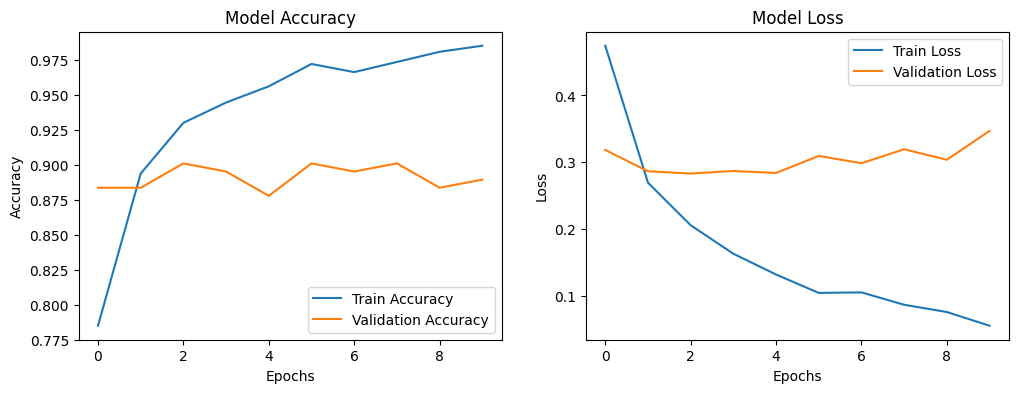

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots training and validation accuracy and loss.
    """
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # Plot Accuracy
    ax[0].plot(history.history['accuracy'], label='Train Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    # Plot Loss
    ax[1].plot(history.history['loss'], label='Train Loss')
    ax[1].plot(history.history['val_loss'], label='Validation Loss')
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.show()

plot_training_history(history)

Once you are comfortable with these basic metrics, we will introduce more detailed evaluation measures like the F1 Score, which balances precision and recall. This gradual progression—from simple accuracy and loss visualization to advanced metrics—helps build a comprehensive understanding of model performance.

## 2.4 Evaluating the Model: F1 Score

Beyond simple accuracy, we also calculate evaluation metrics like the F1 Score. In our code, after training the model on the test set (or the validation splits during cross-validation), we use scikit-learn’s f1_score function to compare the model’s predictions (converted to binary labels with a threshold of 0.5) with the ground truth.

In [ ]:
from sklearn.metrics import f1_score

val_preds = []
val_trues = []
for images, labs in val_ds:
    preds = model.predict(images)
    preds = (preds > 0.5).astype(int).squeeze()
    val_preds.extend(preds.tolist())
    val_trues.extend(labs.numpy().tolist())

f1 = f1_score(val_trues, val_preds)
print("F1 Score for last fold's val set:", f1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
F1 Score for last fold's val set: 0.8774193548387097


### 2.5 Model Saving

In [ ]:
model.save("drive/MyDrive/ra/trained_models/module2crater_classifier1.h5")
print("model saved: module2crater_classifier1.h5")

model saved: module2crater_classifier1.h5
